Natalie LaLuzerne

Numerous feature analysis techniques could add more value to this data set including:
- removing rows with missing data
- transforming the categorical columns into scaled numerical columns so that they can be used in forecasting
- removing the parenthesis form the Order_Demand column since parenthesis have no effect on the order demand of a product
- convert the date column into a Datetime object for use in timeseries forecasting. Many forecasting models in Python utilize the Python Datetime objects.
- create additional time series features based on the date such as dayofweek, quarter, month, year, dayofyear, dayofmonth, and weekofyear 

Imports

In [1]:
import pandas as pd
import numpy as np
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings( "ignore" )
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

Constants

In [2]:
data_path = r'..\Data\Historical_Product_Demand.csv'

Load the data set

In [3]:
data = pd.read_csv( data_path )

Remove all rows with missing data so that missing data does not negatively affect forecasting

In [4]:
data = data.dropna()

Transform the columns from categorical data into scaled numeric data so that it can be used in forecasting. We need to scale the numeric data so that we don't add bias to the model.

In [5]:
labelEncoder = preprocessing.LabelEncoder()
data[ 'Product_Code' ] = labelEncoder.fit_transform( data[ 'Product_Code' ] )
data[ 'Warehouse' ] = labelEncoder.fit_transform( data[ 'Warehouse' ] )
data[ 'Product_Category' ] = labelEncoder.fit_transform( data[ 'Product_Category' ] )

Remove parentheses from Order_Demand column. Parentheses don't have anything to do with the actual data so remove them so that they do not negatively affect forecasting.

In [6]:
rows = [ i for i, r in data.iterrows() if ( '(' in r[ 'Order_Demand' ] or ')' in r[ 'Order_Demand' ] ) ]

In [7]:
for row in rows:
    data.at[ row, 'Order_Demand' ] = data.at[ row, 'Order_Demand' ].replace( '(', '' )
    data.at[ row, 'Order_Demand' ] = data.at[ row, 'Order_Demand' ].replace( ')', '' )

Convert Order_Demand column to numeric. Event though the column was already numbers, the data type of the column was a string as evidenced by the parenthesis in some of the data entries. Change this data into integers to be used in forecasting.

In [8]:
data[ 'Order_Demand' ] = data[ 'Order_Demand' ].astype(int)

Convert the date column into a Datetime object for use in timeseries forecasting. Many forecasting models in Python utilize the Python Datetime objects.

In [9]:
data[ 'Date' ] = pd.to_datetime( data[ 'Date' ] )

Select 3 random products to forecast the Order_Demand. For this project, I chose Product 1348, Product 213, and Product 1501 to forecast the Order_Demand

In [10]:
products = [ 1348, 213, 1501 ]

Select 3 products to forecast the Order_Demand. Separate the 3 products from the rest of the data and create new data frames for each product.

In [11]:
Adata = data.loc[ data[ 'Product_Code' ] == products[ 0 ] ]
Bdata = data.loc[ data[ 'Product_Code' ] == products[ 1 ] ]
Cdata = data.loc[ data[ 'Product_Code' ] == products[ 2 ] ]

Since we are time series forecasting the Order_Demand for each of these 3 products, create separate data frames containing just the Date and Order_Demand for each product

In [12]:
adf = Adata[ [ 'Date', 'Order_Demand' ] ]
bdf = Bdata[ [ 'Date', 'Order_Demand' ] ]
cdf = Cdata[ [ 'Date', 'Order_Demand' ] ]

Set the index for each new data frame as the Date column for plotting purposes

In [13]:
adf.set_index( 'Date', inplace = True )
bdf.set_index( 'Date', inplace = True )
cdf.set_index( 'Date', inplace = True )

Plot the raw unanalyzed data for each of the products

In [14]:
color_pal = [ "#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB" ]

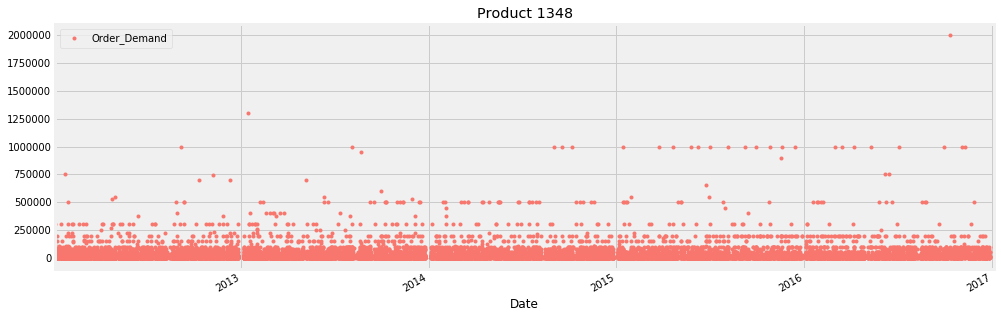

In [15]:
_ = adf.plot( style = '.', figsize = ( 15, 5 ), color = color_pal[ 0 ], title = "Product " + str( products[ 0 ] ) )

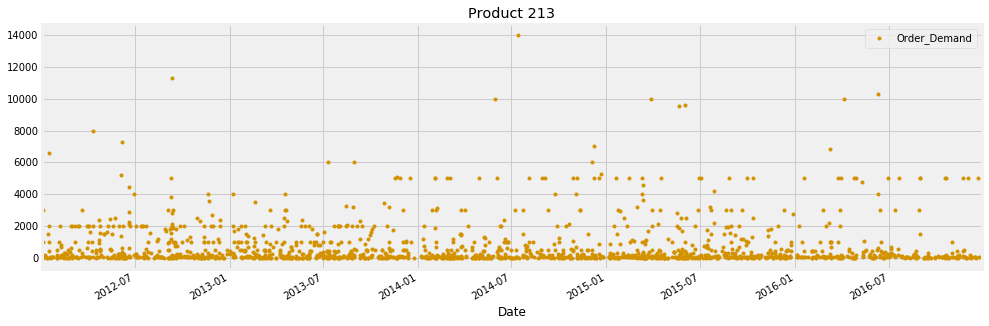

In [16]:
_ = bdf.plot( style = '.', figsize = ( 15, 5 ), color = color_pal[ 1 ], title = "Product " + str( products[ 1 ] ) )

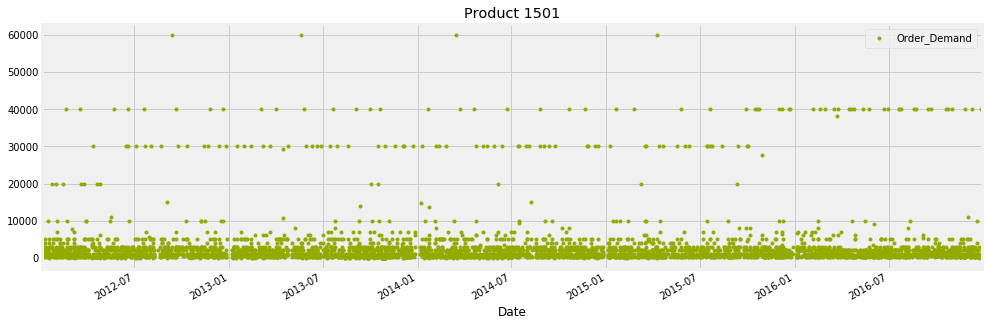

In [17]:
_ = cdf.plot( style = '.', figsize = ( 15, 5 ), color = color_pal[ 2 ], title = "Product " + str( products[ 2 ] ) )

From these plots, it's hard to really see any discernable pattern in the order_demand of any of the three products, but lets looks further.

Split the data into training and testing sets. Cut off the data after 2016 to use as the validation set.

In [18]:
split_date = '01-Jan-2016'
adf_train = adf.loc[ adf.index <= split_date ].copy()
adf_test = adf.loc[ adf.index > split_date ].copy()

In [19]:
bdf_train = bdf.loc[ bdf.index <= split_date ].copy()
bdf_test = bdf.loc[ bdf.index > split_date ].copy()

In [20]:
cdf_train = cdf.loc[ cdf.index <= split_date ].copy()
cdf_test = cdf.loc[ cdf.index > split_date ].copy()

Plot the split data sets to visualize them

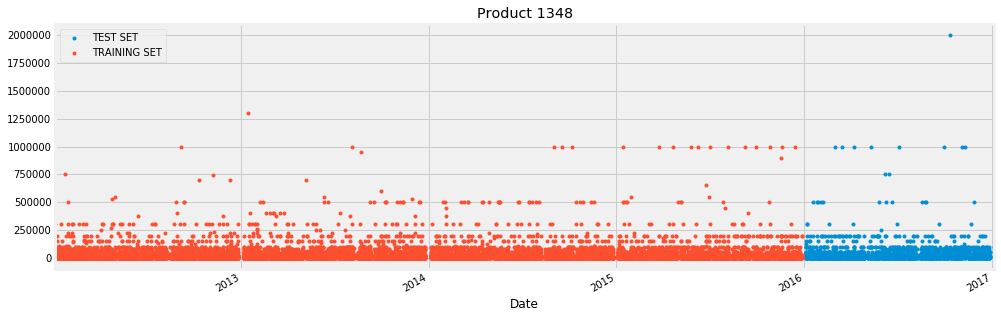

In [21]:
_ = adf_test \
    .rename( columns = { 'Order_Demand': 'TEST SET' } ) \
    .join( adf_train.rename( columns = { 'Order_Demand': 'TRAINING SET' } ), how = 'outer' ) \
    .plot( figsize = ( 15, 5 ), title = 'Product ' + str( products[ 0 ] ), style = '.' )

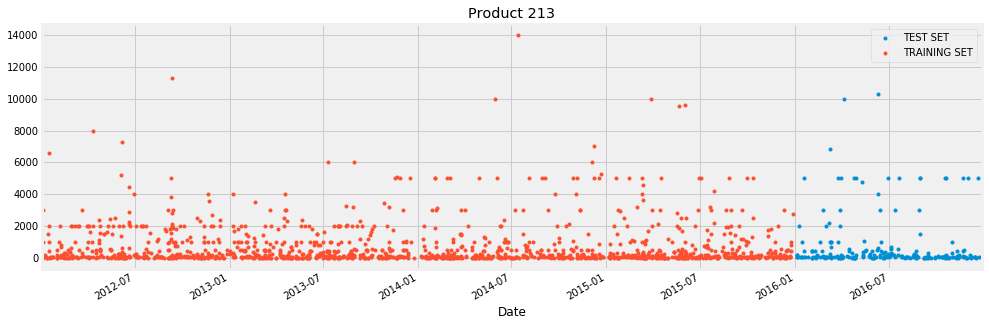

In [22]:
_ = bdf_test \
    .rename( columns = { 'Order_Demand': 'TEST SET' } ) \
    .join( bdf_train.rename( columns = { 'Order_Demand': 'TRAINING SET' } ), how = 'outer' ) \
    .plot( figsize = ( 15, 5 ), title = 'Product ' + str( products[ 1 ] ), style = '.' )

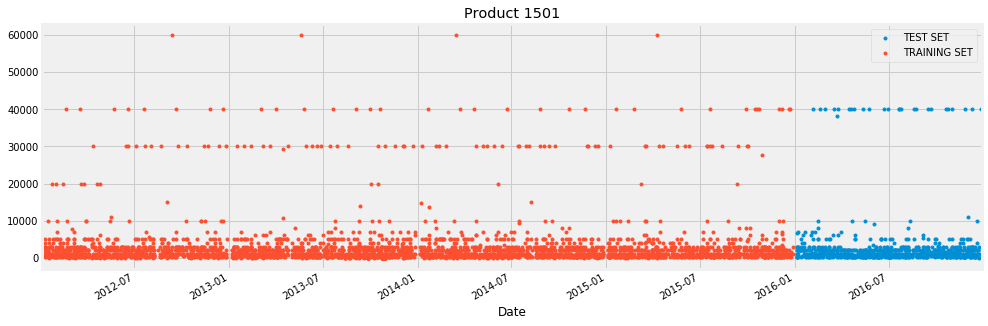

In [23]:
_ = cdf_test \
    .rename( columns = { 'Order_Demand': 'TEST SET' } ) \
    .join( cdf_train.rename( columns = { 'Order_Demand': 'TRAINING SET' } ), how = 'outer' ) \
    .plot( figsize = ( 15, 5 ), title = 'Product ' + str( products[ 2 ] ), style = '.' )

Now we've got the data set split into training and testing sets. Let's see if creating more features from the date will help find any patterns.

Function to create additional time series features based on the date

In [24]:
def create_features( df, label = None ):
    df[ 'date' ] = df.index
    df[ 'dayofweek' ] = df[ 'date' ].dt.dayofweek
    df[ 'quarter' ] = df[ 'date' ].dt.quarter
    df[ 'month' ] = df[ 'date' ].dt.month
    df[ 'year' ] = df[ 'date' ].dt.year
    df[ 'dayofyear' ] = df[ 'date' ].dt.dayofyear
    df[ 'dayofmonth' ] = df[ 'date' ].dt.day
    df[ 'weekofyear' ] = df[ 'date' ].dt.weekofyear
    
    X = df[ [ 'dayofweek', 'quarter', 'month', 'year',
              'dayofyear', 'dayofmonth', 'weekofyear' ] ]
    if label:
        y = df[ label ]
        return X, y
    return X

Create the additional time series features for both the training and test sets for each of the three products

In [25]:
aX_train, ay_train = create_features( adf_train, label = 'Order_Demand' )
aX_test, ay_test = create_features( adf_test, label = 'Order_Demand' )

In [26]:
bX_train, by_train = create_features( bdf_train, label = 'Order_Demand' )
bX_test, by_test = create_features( bdf_test, label = 'Order_Demand' )

In [27]:
cX_train, cy_train = create_features( cdf_train, label = 'Order_Demand' )
cX_test, cy_test = create_features( cdf_test, label = 'Order_Demand' )

Create a Gradient Boosting Model using using XGBoost for each of the three products

In [28]:
areg = xgb.XGBRegressor( n_estimators = 1000 )
areg.fit( aX_train, ay_train, 
         eval_set = [ ( aX_train, ay_train ), ( aX_test, ay_test ) ],
         early_stopping_rounds = 50,
         verbose = False )

c:\users\nlalu\appdata\local\programs\python\python37-32\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\nlalu\appdata\local\programs\python\python37-32\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:20:34] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [29]:
breg = xgb.XGBRegressor( n_estimators = 1000 )
breg.fit( bX_train, by_train, 
         eval_set = [ ( bX_train, by_train ), ( bX_test, by_test ) ],
         early_stopping_rounds = 50,
         verbose = False )

[11:20:35] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [30]:
creg = xgb.XGBRegressor( n_estimators = 1000 )
creg.fit( cX_train, cy_train, 
         eval_set = [ ( cX_train, cy_train ), ( cX_test, cy_test ) ],
         early_stopping_rounds = 50,
         verbose = False )

[11:20:35] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

Plot the feature importances for each of the three products. The importance of a feature represents how much the model relied on a given feature to determine an outcome.

Feature importance for Productn 1348

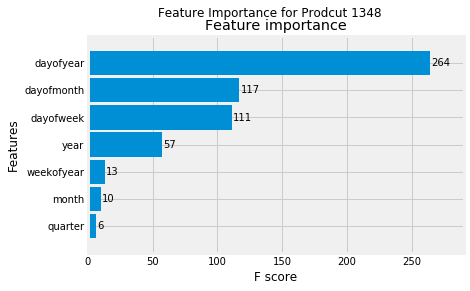

In [31]:
_ = plot_importance( areg, height = 0.9 )
plot = plt.suptitle( 'Feature Importance for Product ' + str( products[ 0 ] ) )

Feature Importance for Product 213

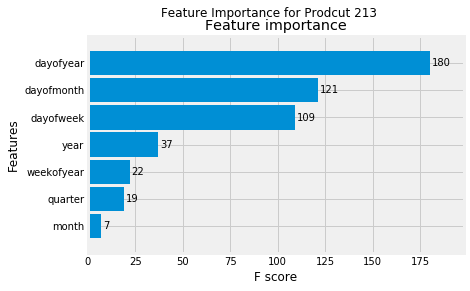

In [32]:
_ = plot_importance( breg, height = 0.9 )
plot = plt.suptitle( 'Feature Importance for Product ' + str( products[ 1 ] ) )

Feature importance for Product 1501

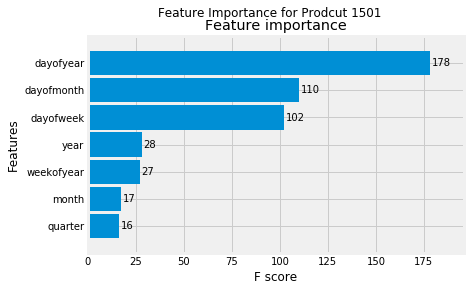

In [33]:
_ = plot_importance( creg, height = 0.9 )
plot = plt.suptitle( 'Feature Importance for Product ' + str( products[ 2 ] ) )

Interesting. The models for each of the three products decided on the dayofyear, dayofmonth, and dayofweek as the top three features for deciding the order demand for a specific product.

Apply time series forecasting on the each of the three test sets

In [34]:
adf_test[ 'Order_Prediction' ] = areg.predict( aX_test )
adf_all = pd.concat( [ adf_test, adf_train ], sort = False )

In [35]:
bdf_test[ 'Order_Prediction' ] = breg.predict( bX_test )
bdf_all = pd.concat( [ bdf_test, bdf_train ], sort = False )

In [36]:
cdf_test[ 'Order_Prediction' ] = creg.predict( cX_test )
cdf_all = pd.concat( [ cdf_test, cdf_train ], sort = False )

Plot the forecasts for each of the three products

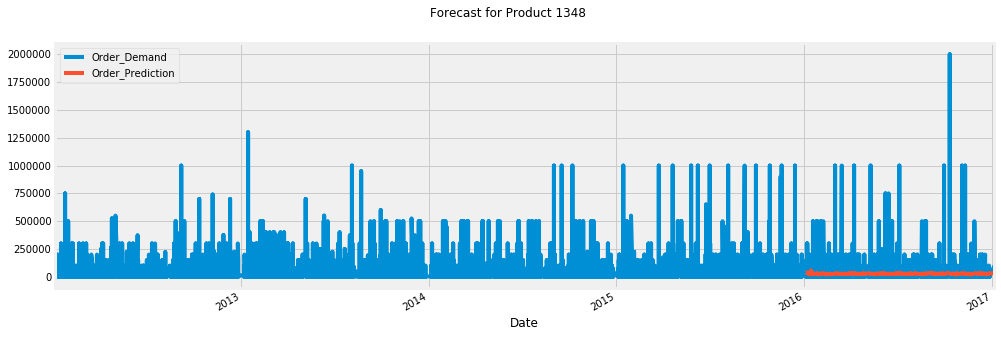

In [37]:
_ = adf_all[ [ 'Order_Demand', 'Order_Prediction' ] ].plot( figsize = ( 15, 5 ) )
plot = plt.suptitle( 'Forecast for Product ' + str( products[ 0 ] ) )

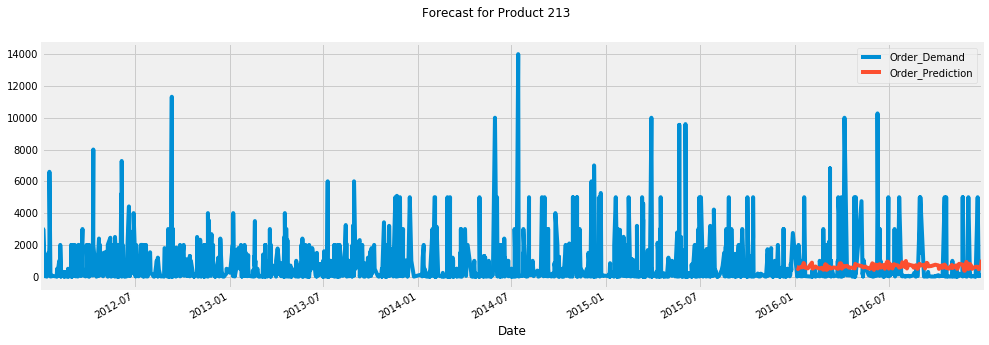

In [38]:
_ = bdf_all[ [ 'Order_Demand', 'Order_Prediction' ] ].plot( figsize = ( 15, 5 ) )
plot = plt.suptitle( 'Forecast for Product ' + str( products[ 1 ] ) )

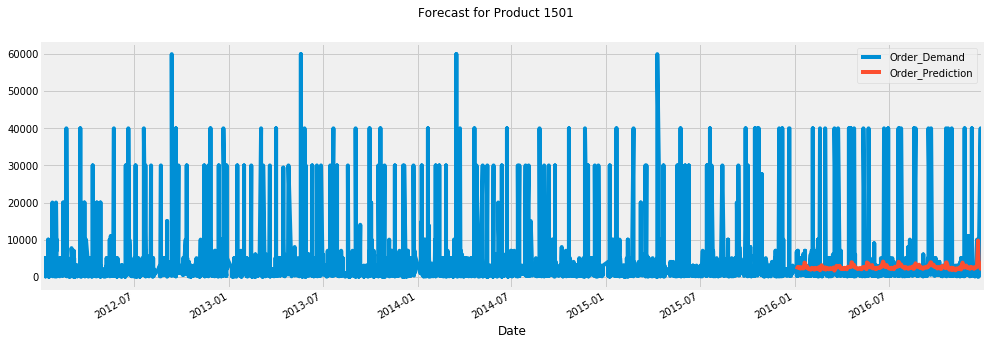

In [39]:
_ = cdf_all[ [ 'Order_Demand', 'Order_Prediction' ] ].plot( figsize = ( 15, 5 ) )
plot = plt.suptitle( 'Forecast for Product ' + str( products[ 2 ] ) )

At first glace, the forecasts for the three products look pretty terrible. Product 1348 seems to be the worst; the forecast seems to be almost a straight line, while the data is much more variant. The forecast for Product 213 seems to be at least trying to pick up on some patterns of the spikes in the data, although the magnitude of the forecast is pretty low and the spikes in the forecast don't seem to line up with any of the spikes in the data. The forecast for product 1501 is interesting. While the magnitude of the forecast for order demand is much lower than the actual data, the forecast does seem to pick up on spikes in the product demand, and the forecast spikes line up pretty well with spikes in the data. Let's zoom in closer to these forecasts to see what they look like up close.

"Zoom-in" on the forecast to get a better look at the forecast and how it compares to the actual data. Look at the first month of predictions for each of the three products.

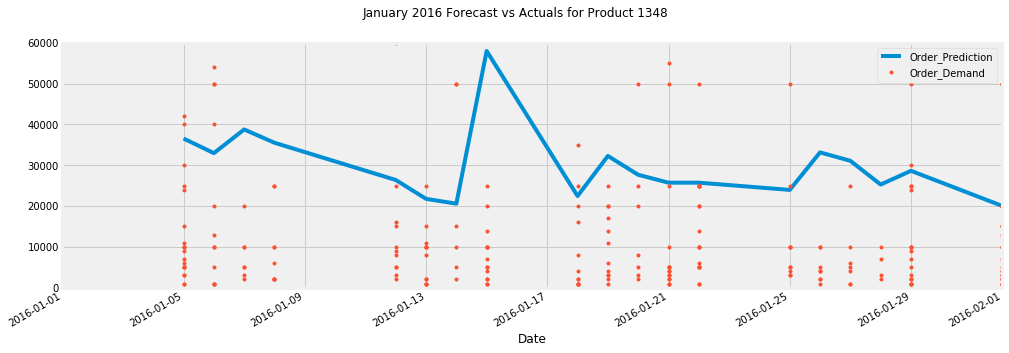

In [40]:
f, ax = plt.subplots( 1 )
f.set_figheight( 5 )
f.set_figwidth( 15 )
_ = adf_all[ [ 'Order_Prediction', 'Order_Demand' ] ].plot( ax = ax, style = [ '-', '.' ] )
ax.set_xbound( lower = '01-01-2016', upper = '02-01-2016' )
ax.set_ylim( 0, 60000 )
plot = plt.suptitle( 'January 2016 Forecast vs Actuals for Product ' + str( products[ 0 ] ) )

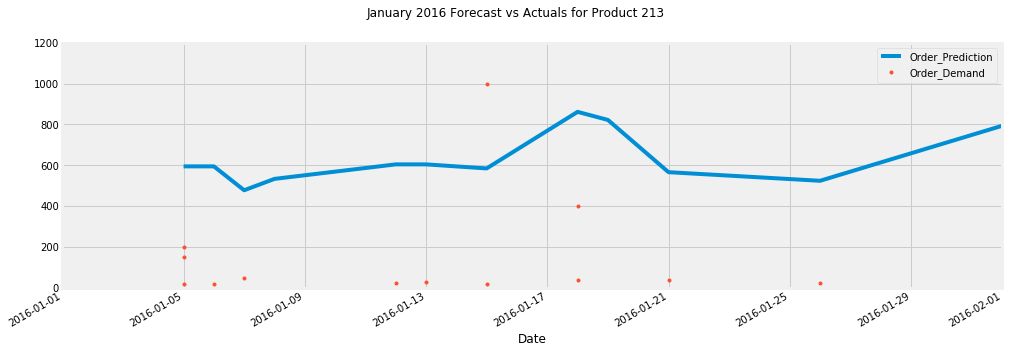

In [41]:
f, ax = plt.subplots( 1 )
f.set_figheight( 5 )
f.set_figwidth( 15 )
_ = bdf_all[ [ 'Order_Prediction', 'Order_Demand' ] ].plot( ax = ax, style = [ '-', '.' ] )
ax.set_xbound( lower = '01-01-2016', upper = '02-01-2016' )
ax.set_ylim( 0, 1200 )
plot = plt.suptitle( 'January 2016 Forecast vs Actuals for Product ' + str( products[ 1 ] ) )

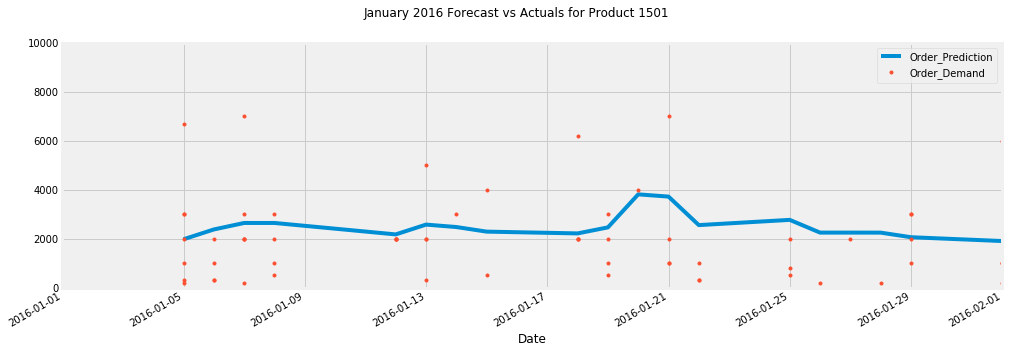

In [42]:
f, ax = plt.subplots( 1 )
f.set_figheight( 5 )
f.set_figwidth( 15 )
_ = cdf_all[ [ 'Order_Prediction', 'Order_Demand' ] ].plot( ax = ax, style = [ '-', '.' ] )
ax.set_xbound( lower = '01-01-2016', upper = '02-01-2016' )
ax.set_ylim( 0, 10000 )
plot = plt.suptitle( 'January 2016 Forecast vs Actuals for Product ' + str( products[ 2 ] ) )

Zooming in to the first month of predictions confirms what the overall picture showed. The forecast for Product 1348 doesn't seem to know what it's doing; it doesn't really match up with the data at all. The forecast for Product 213 is trying to catch on. It got the slight upticks in order demand at the beginning of the month and the middle of the month, but then starts going a little crazy from there. The forecast for Product 1501 actually seems to match the data well; the forecast is right where the majority of data is for the month of January.

"Zoom-out" just a little bit more and look at the first 6 months of prediction for each of the 3 products.

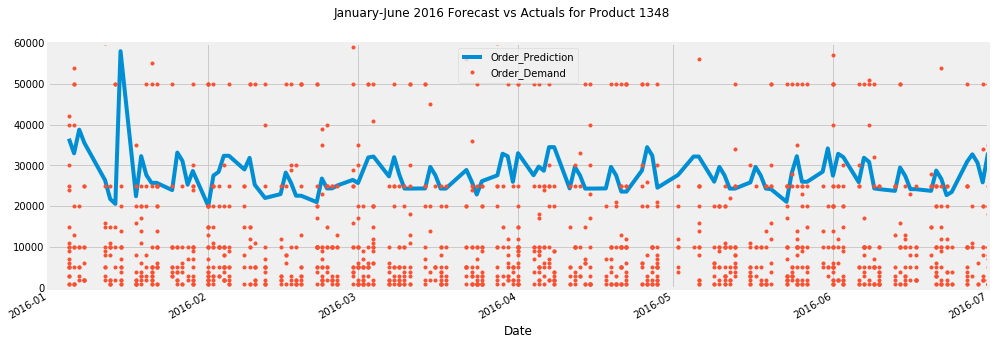

In [43]:
f, ax = plt.subplots( 1 )
f.set_figheight( 5 )
f.set_figwidth( 15 )
_ = adf_all[ [ 'Order_Prediction', 'Order_Demand' ] ].plot( ax = ax, style = [ '-', '.' ] )
ax.set_xbound( lower = '01-01-2016', upper = '07-01-2016' )
ax.set_ylim( 0, 60000 )
plot = plt.suptitle( 'January-June 2016 Forecast vs Actuals for Product ' + str( products[ 0 ] ) )

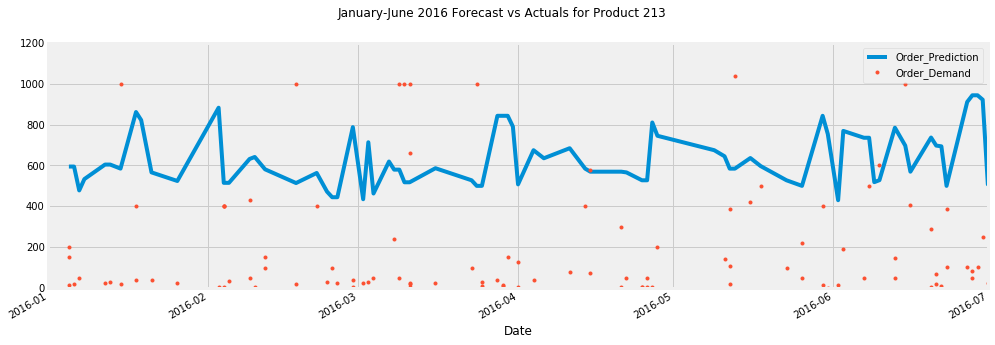

In [44]:
f, ax = plt.subplots( 1 )
f.set_figheight( 5 )
f.set_figwidth( 15 )
_ = bdf_all[ [ 'Order_Prediction', 'Order_Demand' ] ].plot( ax = ax, style = [ '-', '.' ] )
ax.set_xbound( lower = '01-01-2016', upper = '07-01-2016' )
ax.set_ylim( 0, 1200 )
plot = plt.suptitle( 'January-June 2016 Forecast vs Actuals for Product ' + str( products[ 1 ] ) )

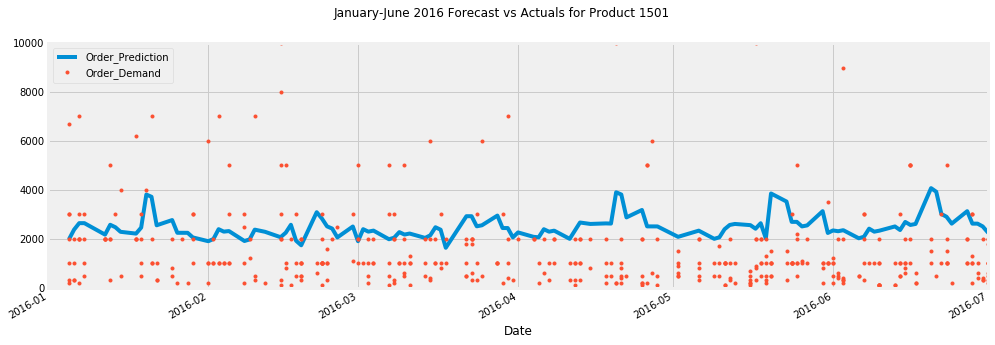

In [45]:
f, ax = plt.subplots( 1 )
f.set_figheight( 5 )
f.set_figwidth( 15 )
_ = cdf_all[ [ 'Order_Prediction', 'Order_Demand' ] ].plot( ax = ax, style = [ '-', '.' ] )
ax.set_xbound( lower = '01-01-2016', upper = '07-01-2016' )
ax.set_ylim( 0, 10000 )
plot = plt.suptitle( 'January-June 2016 Forecast vs Actuals for Product ' + str( products[ 2 ] ) )

Now it's obvious that the forecast for Product 1348 is not a straight line, and in fact is not all that bad. Spikes in the forecast seem to match up pretty well with the spikes in the data. The forecast for Product 213 is garbage. The forecast for Product 1501 is also not bad. The spikes in the forecast at least somewhat line up with the spikes in the data. The new and improved forecast rankings seem to be Product 1348's forecast in first, Product 1501's forecast in second, and Product 213's forecast bringing up the rear.

"Zoom-out" one more time and look at the first year of predictions for each of the three products

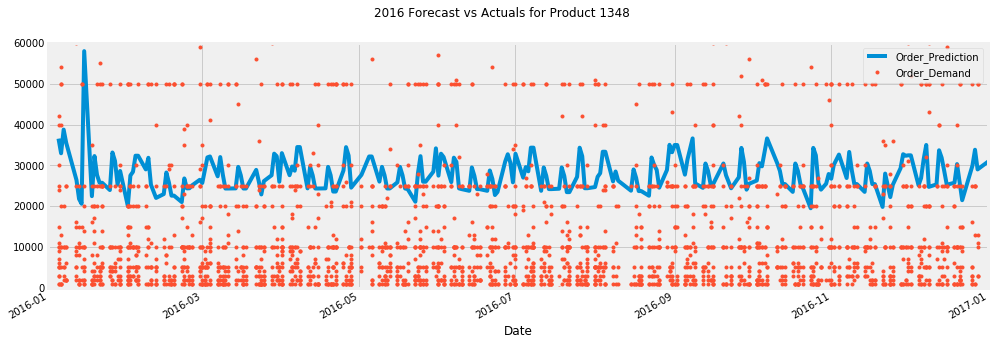

In [46]:
f, ax = plt.subplots( 1 )
f.set_figheight( 5 )
f.set_figwidth( 15 )
_ = adf_all[ [ 'Order_Prediction', 'Order_Demand' ] ].plot( ax = ax, style = [ '-', '.' ] )
ax.set_xbound( lower = '01-01-2016', upper = '01-01-2017' )
ax.set_ylim( 0, 60000 )
plot = plt.suptitle( '2016 Forecast vs Actuals for Product ' + str( products[ 0 ] ) )

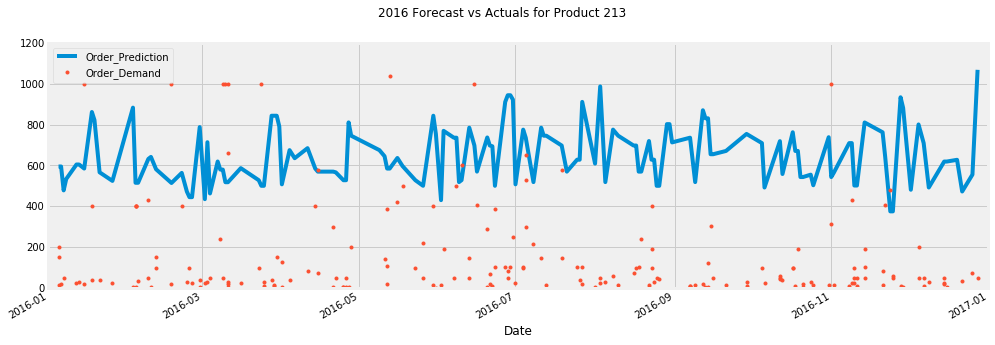

In [47]:
f, ax = plt.subplots( 1 )
f.set_figheight( 5 )
f.set_figwidth( 15 )
_ = bdf_all[ [ 'Order_Prediction', 'Order_Demand' ] ].plot( ax = ax, style = [ '-', '.' ] )
ax.set_xbound( lower = '01-01-2016', upper = '01-01-2017' )
ax.set_ylim( 0, 1200 )
plot = plt.suptitle( '2016 Forecast vs Actuals for Product ' + str( products[ 1 ] ) )

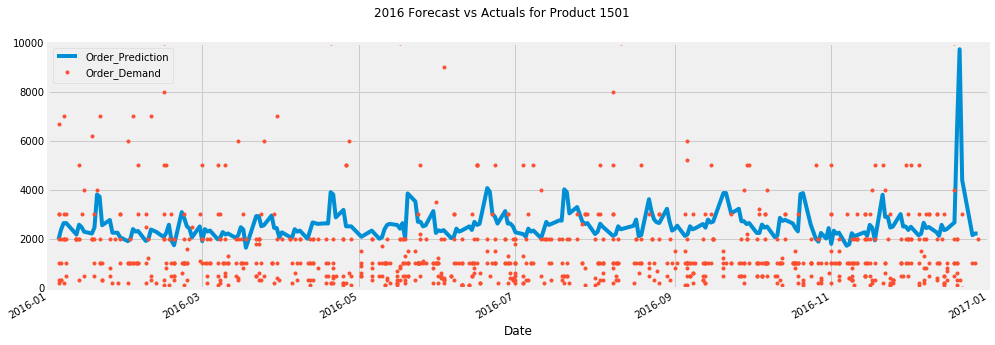

In [48]:
f, ax = plt.subplots( 1 )
f.set_figheight( 5 )
f.set_figwidth( 15 )
_ = cdf_all[ [ 'Order_Prediction', 'Order_Demand' ] ].plot( ax = ax, style = [ '-', '.' ] )
ax.set_xbound( lower = '01-01-2016', upper = '01-01-2017' )
ax.set_ylim( 0, 10000 )
plot = plt.suptitle( '2016 Forecast vs Actuals for Product ' + str( products[ 2 ] ) )

It becomes harder to see patterns and matches in the forecasts as you zoom out, which was clearly confirmed when looking at all of the data at first. The forecast for Product 1348 still seems to be the best, with peaks in the forecast seemingly roughly matching up with peaks in the data. The forecast for Product 1501 doesn't seem to be too bad either; it's trying to pick up on spikes in the data ad they seem to somewhat follow the data. As I said previously, the forecast for Product 213 is trash; the forecast doesn't really match any patterns in the data.

Calculate the root mean squared error for each of the three products

In [49]:
print( "RMSE error for Product " + str( products[ 0 ] ) + ":  " +
       str( mean_squared_error( y_true = adf_test[ 'Order_Demand' ], 
                               y_pred = adf_test[ 'Order_Prediction' ] ) ) )
print( "RMSE error for Product " + str( products[ 1 ] ) + ":  " +
       str( mean_squared_error( y_true = bdf_test[ 'Order_Demand' ], 
                               y_pred = bdf_test[ 'Order_Prediction' ] ) ) )
print( "RMSE error for Product " + str( products[ 2 ] ) + ":  " +
       str( mean_squared_error( y_true = cdf_test[ 'Order_Demand' ], 
                               y_pred = cdf_test[ 'Order_Prediction' ] ) ) )

RMSE error for Product 1348:  6858747296.085493
RMSE error for Product 213:  2694978.8182104486
RMSE error for Product 1501:  44454712.78928638


Calculate the mean absolute error for each of the three products

In [50]:
print( "MAE error for Product " + str( products[ 0 ] ) + ":  " +
       str( mean_absolute_error( y_true = adf_test[ 'Order_Demand' ], 
                               y_pred = adf_test[ 'Order_Prediction' ] ) ) )
print( "MAE error for Product " + str( products[ 1 ] ) + ":  " +
       str( mean_absolute_error( y_true = bdf_test[ 'Order_Demand' ], 
                               y_pred = bdf_test[ 'Order_Prediction' ] ) ) )
print( "MAE error for Product " + str( products[ 2 ] ) + ":  " +
       str( mean_absolute_error( y_true = cdf_test[ 'Order_Demand' ], 
                               y_pred = cdf_test[ 'Order_Prediction' ] ) ) )

MAE error for Product 1348:  32674.31034857441
MAE error for Product 213:  958.4842311506229
MAE error for Product 1501:  2678.2724523468537


Those are big numbers. All I can really say is that some of the order demands were pretty large numbers, for example, any of the spikes you see in the data. So when the forecast doesn't account for the spike, obviously the error will be very large at that point. But also, it was obvious that none of the forecasts were perfect; while at least the forecasts for Product 1348 and 1501 may have caught on to some of the order demand trends, they still didn't predict the actual quantity correctly, so it makes sense that the errors are huge.